#### Large Language Models are stateless 
Each time it's prompted to generate a context, it has no recollection of prior context, in order to provide historical information, we need to keep track of previous conversation and context.

### Building a chatbot memory system

In [1]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

In [2]:
prompt = ChatPromptTemplate.from_messages([
    ("system", """You are a helpful assistant. Answer all questions to the best
         of your ability."""),
     ("placeholder", "{messages}"),
])

model = ChatOpenAI()

In [3]:
chain = prompt | model

chain.invoke({
    "messages": [
        ("human","""Translate this sentence from English to French: I love
             programming."""),
        ("ai", "J'adore programmer."),
        ("human", "What did you just say?"),
    ],
})

AIMessage(content='I said, "J\'adore programmer," which means "I love programming" in English.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 63, 'total_tokens': 83, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-Cn2m5od9tGPmsgQRWpvoC840QIxjQ', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--d609c520-4516-444c-b1f4-dbb22884bb53-0', usage_metadata={'input_tokens': 63, 'output_tokens': 20, 'total_tokens': 83, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

### LangGraph

LangGraph was developed to implement multiactor, multistep, stateful cognitive architectures, called graphs. There can be multiple actors for example, an LLM prompt asking a search tool for the results of a given search query. We need to make sense of the back-and-forth between multiple actors. Communication across steps requires tracking some state.

Each graph is made up of following components:

State:
The data received from outside the application, modified and produced by the application while it’s running.

Nodes:
Each step to be taken. Nodes are simply Python/JS functions, which receive the current state as input and can return an update to that state.

Edges:
The connections between nodes. Edges determine the path taken from the first node to the last, and they can be fixed (that is, after Node B, always visit node D)
or conditional.

#### Let's create a simple chatbot using LangGraph

In [4]:
from typing import Annotated, TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

In [5]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages`
    # function in the annotation defines how this state should
    # be updated (in this case, it appends new messages to the
    # list, rather than replacing the previous messages)
    messages: Annotated[list, add_messages]

builder = StateGraph(State)

Each node will receive the current state as well as a list of messages and it'll append it's own message to that list.

In [6]:
from langchain_openai import ChatOpenAI

def chatbot(state: State):
    answer = model.invoke(state["messages"])
    return {"messages": [answer]}

builder.add_node("chatbot", chatbot)

In [7]:
builder.add_edge(START, 'chatbot')
builder.add_edge('chatbot', END)

graph = builder.compile()

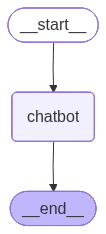

In [8]:
graph

In [9]:
from langchain_core.messages import HumanMessage, AIMessage

input = {"messages": [HumanMessage('hi')]}

In [10]:
input

{'messages': [HumanMessage(content='hi', additional_kwargs={}, response_metadata={})]}

In [11]:
list(graph.stream(input))

[{'chatbot': {'messages': [AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 8, 'total_tokens': 17, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-Cn2m5snFciNulDe6lC5f2cn5EIesO', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--a733695f-2e22-4e8c-8db8-3313516f94dd-0', usage_metadata={'input_tokens': 8, 'output_tokens': 9, 'total_tokens': 17, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}}]

In [12]:
for chunk in graph.stream(input):
    print(chunk['chatbot']['messages'][0].content)

Hello! How can I assist you today?


In [13]:
del builder.nodes["chatbot"]

In [14]:
buil